
## Image Captioning with Conditioned LSTM Generators


Import all required packages. 

In [ ]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.optimizers import Adam

from google.colab import drive

### Access to the flickr8k data

Downloaded the dataset and then upload it again to my own drive.


In [ ]:
#Assign the name of your data folder.
my_data_dir="flickr8k_data_dir"

### Mounting your GDrive so you can access the files from Colab

In [ ]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
#copy paste that code in the text box that will appear below
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Part I: Image Encodings (2.5 pts)

> Indented block



The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists. 

In [ ]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [ ]:
train_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
dev_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt')
test_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

Let's see how many images there are

In [ ]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [ ]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [ ]:
IMG_PATH = '/content/gdrive/My Drive/'+my_data_dir+'/Flickr_Data/Flickr_Data/Images'

We can use PIL to open the image and matplotlib to display it. 

# Display image

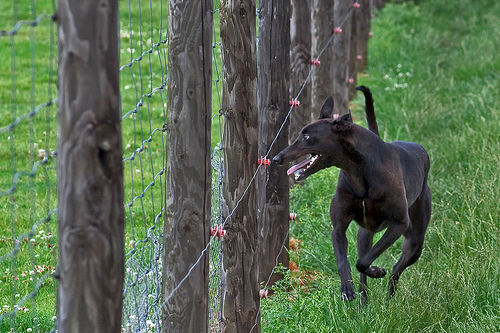

In [ ]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

In [ ]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

We can use PIL to resize the image and then divide every value by 255. 

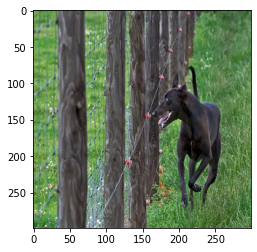

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

# Let's put this all in a function for convenience. 

In [ ]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

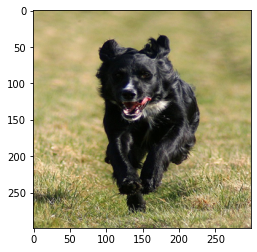

In [ ]:
plt.imshow(get_image(dev_list[25]))

In [ ]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [ ]:
encoded_image = img_encoder.predict(np.array([new_image]))

In [ ]:
new_input

<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
encoded_image

array([[0.6380654 , 0.4887303 , 0.05526233, ..., 0.64255756, 0.29595238,
        0.49004295]], dtype=float32)

We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, dev, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

In [ ]:
def img_generator(img_list):
    for i in img_list:
      image = get_image(i)
      yield np.asarray([image])

In [ ]:
train_list[0]

'2513260012_03d33305cf.jpg'

Now we can encode all images (this takes a few minutes).

In [ ]:
enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


6000/6000 [==============================] - 1534s 256ms/step


In [ ]:
enc_train[11]

array([0.26818526, 1.0321674 , 0.58516204, ..., 1.2316746 , 0.17969309,
       0.22405308], dtype=float32)

In [ ]:
enc_dev = img_encoder.predict(img_generator(dev_list), steps=len(dev_list), verbose=1)

1000/1000 [==============================] - 254s 254ms/step


In [ ]:
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1000/1000 [==============================] - 252s 252ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy", enc_train)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy", enc_dev)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_test.npy", enc_test)

## Part II Text (Caption) Data Preparation (1.25 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. 
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [ ]:
# Read the image description, preprocess and add it to image_descriptions dictionary
# Input: filename (ex.Flickr8k.token.txt)
# Output: dictionary with filename as key, list of words from the five descriptions as value
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)    
    file = open(filename,'r')
    lines = file.readlines()
    for line in lines:
      fname = line.split('#')[0]
      description = line.split('#')[1].lower()
      description = description.replace('\t',' ')
      description = '<START>'+description[1:]
      description = description[:-1] +" <END>";
      description_split = description.split()
      image_descriptions[fname].append(description_split)
    return image_descriptions

# read_image_descriptions("gdrive/My Drive/"+my_data_dir+"/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [ ]:
# Populating description dictionary using the above method
descriptions = read_image_descriptions("gdrive/My Drive/"+my_data_dir+"/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [ ]:
# Printing the first description from dev_list
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


Running the previous cell should print:     
`[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
`    

### Creating Word Indices

In [ ]:
# Creating the unique words list, using the set and list sort method
train_img_description_set = set() 
train_desc_dict = {}
for i in train_list:
  desc_list = descriptions[i]
  train_desc_dict[i] = desc_list
  for d in desc_list:
    [train_img_description_set.add(t) for t in d]
train_desc_list = list(train_img_description_set)
train_desc_list.sort()

In [ ]:
# Creating the dictionaries id_to_word(index as key, word as value) and word_to_id(word as key, index as value)
id_to_word = {}
word_to_id = {}
train_desc_list
ix = 0
for word in train_desc_list: 
    word_to_id[word] = ix 
    id_to_word[ix] = word 
    ix += 1

In [ ]:
word_to_id['dog'] # should print an integer

2126

In [ ]:
id_to_word[1985] # should print a token

'delivery'

In [ ]:
len(id_to_word)

8280

In [ ]:
len(word_to_id)

8280

In [ ]:
len(train_desc_list)

8280

## Part III Basic Decoder Model (2.5 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = (len(word_to_id))

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 300)           2311200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              3330048   
_________________________________________________________________
dense_3 (Dense)              (None, 7704)              7896600   
Total params: 13,537,848
Trainable params: 13,537,848
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vocab_size

7704

The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

In [ ]:
def text_training_generator(batch_size=128):
    X2, y = list(), list()
    n=0
    while 1:
      for key, desc_list in train_desc_dict.items():
        for desc in desc_list:
            # encode the sequence
            seq = [word_to_id[word] for word in desc if word in word_to_id]
            # split one sequence into multiple X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence using pad_sequence
                in_seq = pad_sequences([in_seq], maxlen=MAX_LEN,value=0,padding='post')[0]
                # encode output sequence using to_categorical
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X2.append(in_seq)
                y.append(out_seq)
                n+=1          
                if n==batch_size:
                    yield (np.array(X2),np.array(y))
                    X2, y = list(), list()
                    n=0


### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [ ]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 
print(steps)

1875


In [ ]:
from datetime import datetime
now = datetime.now()

model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=10)

print("Time taken: ", (datetime.now() - now).total_seconds())

Epoch 1/10
1875/1875 [==============================] - 81s 42ms/step - loss: 4.7091 - accuracy: 0.2448
Epoch 2/10
1875/1875 [==============================] - 78s 41ms/step - loss: 3.7688 - accuracy: 0.3499
Epoch 3/10
1875/1875 [==============================] - 78s 42ms/step - loss: 3.5418 - accuracy: 0.3706
Epoch 4/10
1875/1875 [==============================] - 77s 41ms/step - loss: 3.4658 - accuracy: 0.3788
Epoch 5/10
1875/1875 [==============================] - 78s 41ms/step - loss: 3.3937 - accuracy: 0.3880
Epoch 6/10
1875/1875 [==============================] - 77s 41ms/step - loss: 3.2935 - accuracy: 0.3960
Epoch 7/10
1875/1875 [==============================] - 78s 41ms/step - loss: 3.3100 - accuracy: 0.3961
Epoch 8/10
1875/1875 [==============================] - 77s 41ms/step - loss: 3.2582 - accuracy: 0.4011
Epoch 9/10
1875/1875 [==============================] - 78s 41ms/step - loss: 3.2408 - accuracy: 0.4037
Epoch 10/10
1875/1875 [==============================] - 78s 41m

Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [ ]:
# Simple decoder which predicts the most likely word
def decoder():
    output_list = ["<START>"]
    t=True
    while t:
      word_indices = [word_to_id[i] for i in output_list]
      input = pad_sequences([word_indices],maxlen=MAX_LEN, padding='post')
      output = model.predict(input)
      v = output[0]
      predicted_word = id_to_word[v.argmax(axis=0)]
      output_list.append(predicted_word)
      if(predicted_word == "<END>"):
        t=False
    return output_list

In [ ]:
print(decoder())

['<START>', 'a', 'man', 'is', 'standing', 'on', 'a', 'beach', 'with', 'his', 'arms', 'around', 'him', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

In [ ]:
# Sample decoder method to predict the next word from the distribution using numpy random multinomial function
def sample_decoder():
    output_list = ["<START>"]
    t=True
    while (len(output_list) <=40) and t:
      word_indices = [word_to_id[i] for i in output_list]
      input = pad_sequences([word_indices],maxlen=MAX_LEN, padding='post')
      output = model.predict(input)
      pred = output[0]
      pred = np.asarray(pred).astype('float64')
      # Normalizing the log probabilities
      pred = np.log(pred) / 1.0
      exp_pred = np.exp(pred)
      pred = exp_pred / np.sum(exp_pred)
      # Predicts a single word from the whole vocab list
      probs = np.random.multinomial(1, pred, 1)
      ind = np.argmax(probs)

      predicted_word = id_to_word[ind]
      output_list.append(predicted_word)

      if(predicted_word == "<END>"):
        t=False
    return output_list

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

In [ ]:
for i in range(10): 
    print(sample_decoder())

['<START>', 'a', 'boy', 'wearing', 'a', 'winter', 'shirt', '.', '<END>']
['<START>', 'a', 'woman', 'of', 'nose', 'there', 'is', 'walking', 'to', 'has', 'a', 'grey', 'sky', 'under', 'her', 'sunglasses', '.', '<END>']
['<START>', 'men', 'standing', 'in', 'the', 'snow', 'near', 'cliff', 'and', 'phone', 'his', ',', 'ocean', 'behind', '.', '<END>']
['<START>', 'a', 'man', 'in', 'a', 'large', 'headband', 'is', 'parked', 'by', 'a', 'group', 'of', 'people', 'in', 'the', 'distance', '.', '<END>']
['<START>', 'a', 'young', 'man', 'with', 'a', 'yellow', 'shirt', 'people', 'smiles', 'at', 'the', 'sun', 'near', 'a', 'fetched', '.', '<END>']
['<START>', 'a', 'brown', 'dog', 'is', 'running', 'through', 'snow', 'at', 'the', 'beach', '.', '<END>']
['<START>', 'man', 'sits', 'on', 'a', 'rock', 'beside', 'the', 'water', '.', '<END>']
['<START>', 'a', 'man', 'wearing', 'a', 'toy', 'and', 'snow', 'is', 'on', 'a', 'trick', 'covered', 'in', 'his', 'jackets', 'in', 'the', 'snow', 'and', 'a', 'person', 'sniffs

In [ ]:
id_to_word[4018]

'masses'

## Part III - Conditioning on the Image (3.75 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          614700      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 40, 300)      0           dense_4[0][0]                    
____________________________________________________________________________________________

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

Modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above.  

You need to find the image encoding that belongs to each image. You can use the fact that the index of the image in `train_list` is the same as the index in enc_train and enc_dev. 

If you have previously saved the image encodings, you can load them from disk: 

In [ ]:
enc_train = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy")
enc_dev = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy")

In [ ]:
enc_train[0]

array([0.1037339 , 0.25207853, 0.07683969, ..., 0.17885208, 1.6637325 ,
       0.56516266], dtype=float32)

In [ ]:
def training_generator(batch_size=128):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
      j=0
      for key, desc_list in train_desc_dict.items():
        encoded_image = enc_train[j]
        for desc in desc_list:
            # encode the sequence
            seq = [word_to_id[word] for word in desc if word in word_to_id]

            # split one sequence into multiple X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=MAX_LEN,value=0,padding='post')[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(encoded_image)
                X2.append(in_seq)
                y.append(out_seq)
                n+=1
                if n==batch_size:
                    yield ([np.array(X1), np.array(X2)],np.array(y))
                    X1, X2, y = list(), list(), list()
                    n=0
        j+=1


You should now be able to train the model as before: 

In [ ]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 
print(steps)

1875


In [ ]:
model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.1217 - accuracy: 0.4479
Epoch 2/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.1145 - accuracy: 0.4486
Epoch 3/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.0800 - accuracy: 0.4503
Epoch 4/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.0578 - accuracy: 0.4527
Epoch 5/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.0925 - accuracy: 0.4525
Epoch 6/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.0763 - accuracy: 0.4555
Epoch 7/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.0791 - accuracy: 0.4565
Epoch 8/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.0481 - accuracy: 0.4585
Epoch 9/10
1875/1875 [==============================] - 60s 32ms/step - loss: 3.0476 - accuracy: 0.4596
Epoch 10/10
1875/1875 [==============================] - 60s 32m

Again, continue to train the model until you hit an accuracy of about 40%. This may take a while. I strongly encourage you to experiment with cloud GPUs using the GCP voucher for the class. 

You can save your model weights to disk and continue at a later time. 

In [ ]:
model.save_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

to load the model: 

In [ ]:
model.load_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [ ]:
def image_decoder(enc_image): 
    output_list = ["<START>"]
    t=True
    while t:
      word_indices = [word_to_id[i] for i in output_list]
      text_input = pad_sequences([word_indices],maxlen=MAX_LEN, padding='post')
      output = model.predict((enc_image,text_input),verbose=0)
      v = output[0]
      predicted_word = id_to_word[v.argmax(axis=0)]
      output_list.append(predicted_word)
      if(predicted_word == "<END>"):
        t=False
    return output_list
    

In [ ]:
enc_train[0].shape

(2048,)

In [ ]:
np.array(enc_train[0])

array([0.1037339 , 0.25207853, 0.07683969, ..., 0.17885208, 1.6637325 ,
       0.56516266], dtype=float32)

As a sanity check, you should now be able to reproduce (approximately) captions for the training images. 

['<START>', 'two', 'brown', 'dogs', 'run', 'on', 'the', 'sand', '.', '<END>']

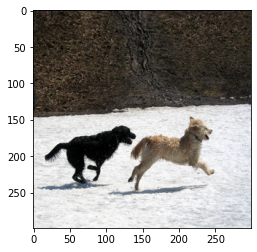

In [ ]:
# Training image test-1
t = np.array(enc_train[0]).reshape(1,2048)
plt.imshow(get_image(train_list[0]))
image_decoder(t)

['<START>', 'a', 'man', 'is', 'climbing', 'a', 'rock', 'face', '.', '<END>']

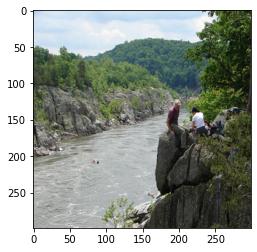

In [ ]:
# Training image test-2
t = np.array(enc_train[3450]).reshape(1,2048)
plt.imshow(get_image(train_list[3450]))
image_decoder(t)

You should also be able to apply the model to dev images and get reasonable captions:

['<START>',
 'a',
 'boy',
 'in',
 'a',
 'grey',
 'jacket',
 'is',
 'standing',
 'on',
 'a',
 'beach',
 '.',
 '<END>']

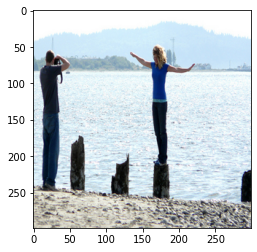

In [ ]:
# Testing dev image 1
t = np.array(enc_dev[250]).reshape(1,2048)
plt.imshow(get_image(dev_list[250]))
image_decoder(t)

['<START>',
 'a',
 'young',
 'boy',
 'playing',
 'in',
 'a',
 'play',
 'field',
 '<END>']

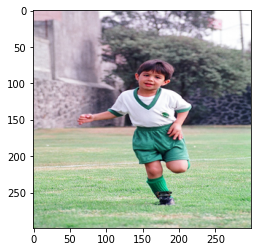

In [ ]:
# Testing dev image 2
t = np.array(enc_dev[345]).reshape(1,2048)
plt.imshow(get_image(dev_list[345]))
image_decoder(t)